In [1]:
from __future__ import print_function
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
# Training settings
use_cuda = True
seed = int(time.time())
epochs = 10
log_interval = 100
batch_size = 32
test_batch_size = 32
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4

In [3]:
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, **kwargs)

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, shuffle=False, **kwargs)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(400, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
#         self.msra_init()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 400)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x)
    
    def msra_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, math.sqrt(2.0 / n))

In [5]:
model = Net()
if use_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

In [6]:
losses = []

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss.data.cpu().numpy())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data),
                len(train_loader.dataset), 100. * batch_idx / len(
                    train_loader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(
        test_loader)  # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
          format(test_loss, correct,
                 len(test_loader.dataset), 100. * correct / len(
                     test_loader.dataset)))

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
test(epoch)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.330851
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.292078
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.194024
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.953787
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.106939
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.998696
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.786219
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.953417
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.819096
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.481907
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.636282
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.758203
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.590373
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.643961
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.666894
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.600801
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.761935
Train Epoch: 2 [3200/50000 (6%)]	Loss: 1.465265
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.674551
Train Epoch: 2 [9600/50000 (19%)]	Loss: 1.731768
Train Epoch: 2 [12

In [8]:
params = [param.data.cpu().numpy() for param in model.parameters()]
filters = params[0]
losses = np.concatenate(losses)

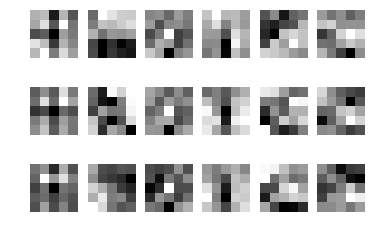

In [9]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(3, 6)
for i in range(3):
    for j in range(6):
        axarr[i, j].imshow(filters[j, i, ...], cmap='gray')
        axarr[i, j].axis('off')
plt.show()

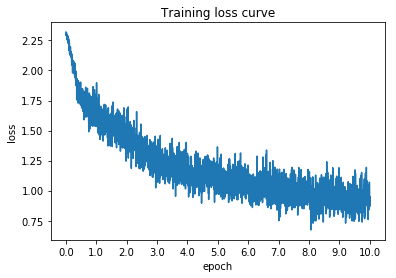

In [15]:
smooth_iter = 5
loss_smooth = losses.reshape(int(losses.size / smooth_iter), smooth_iter).mean(axis=1)
plt.plot(loss_smooth)
plt.title('Training loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
step = int(len(loss_smooth) / 10)
x = np.array(range(0, len(loss_smooth) + 1, step))
labels = x / step
plt.xticks(x, labels)
plt.show()